In [56]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
from tqdm.notebook import tqdm
import os
import threading
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from glob import glob
import shutil
# 쓰레드 함수 정의
def scrape_data(thread_id, sigungu_list_chunk):
    # 각 쓰레드별 저장 디렉토리 생성
    save_dir = f'/home/koo4802/dev_ws/eda/data/Thread{thread_id}'
    os.makedirs(save_dir, exist_ok=True)
    
    options = webdriver.ChromeOptions()
    prefs = {'download.default_directory': save_dir,
             'download.prompt_for_download': False,
             'download.directory_upgrade': True,
             'safebrowsing.enabled': False}
    
    options.add_experimental_option('prefs', prefs)
    
    url = "https://www.opinet.co.kr/searRgSelect.do"
    driver = webdriver.Chrome(service=Service("/home/koo4802/dev_ws/eda/driver/chromedriver"),
                              options=options)
    
    for _ in range(2):  # 페이지 로딩 재시도
        driver.get(url)
        time.sleep(1)
    
    # 서울시 선택 (서울시 value는 "01"입니다)
    sido_btn = driver.find_element(By.ID, "SIDO_NM0")
    sido_option = sido_btn.find_elements(By.TAG_NAME, "option")
    sido_list = [value for option in sido_option if len(value := option.get_attribute("value"))>0]
    sido_btn.send_keys(sido_list[0])  # 서울시 선택
    time.sleep(1)
    
    # 각 시군구별로 처리 (입력받은 시군구 리스트 청크만 처리)
    for option in tqdm(sigungu_list_chunk, desc=f"Thread {thread_id}"):
        sigungu_btn = driver.find_element(By.ID, "SIGUNGU_NM0")
        sigungu_btn.send_keys(option)
        driver.implicitly_wait(3)
        driver.refresh()
        
        # 저장 버튼 클릭
        save = WebDriverWait(driver, timeout=40).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "btn_type6_ex_save")))
        save.click()
        
        # 파일이 다운로드될 때까지 대기
        path = f"{save_dir}/지역_*"
        current_count = len(glob(path))
        while len(glob(path)) <= current_count:
            time.sleep(0.1)
        # 파일 이름 변경
        time.sleep(1)  # 파일이 완전히 다운로드될 때까지 추가 대기
        downloaded_files = glob(f"{save_dir}/지역_*")
        if downloaded_files:
            latest_file = max(downloaded_files, key=os.path.getctime)
            new_filename = f"{save_dir}/{option}.xls"
            try:
                os.rename(latest_file, new_filename)
            except FileExistsError:
                os.remove(new_filename)  # 기존 파일이 있다면 삭제
                os.rename(latest_file, new_filename)
    # 모든 파일을 부모 디렉토리로 이동
    parent_dir = os.path.dirname(save_dir)
    for file in os.listdir(save_dir):
        src_path = os.path.join(save_dir, file)
        dst_path = os.path.join(parent_dir, file)
        try:
            shutil.move(src_path, dst_path)
        except FileExistsError:
            os.remove(dst_path)  # 기존 파일이 있다면 삭제
            shutil.move(src_path, dst_path)
    
    # 빈 디렉토리 삭제
    os.rmdir(save_dir)
    driver.quit()

# 메인 코드
def main():
    # 먼저 시도 목록 가져오기
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=Service("/home/koo4802/dev_ws/eda/driver/chromedriver"),
                              options=options)
    url = "https://www.opinet.co.kr/searRgSelect.do"
    for _ in range(2):
        driver.get(url)
        time.sleep(1)
        
    sido_btn = driver.find_element(By.ID, "SIDO_NM0")
    sido_option = sido_btn.find_elements(By.TAG_NAME, "option")
    sido_list = [value for option in sido_option if len(value := option.get_attribute("value"))>0]

    sigungu_btn = driver.find_element(By.ID, "SIGUNGU_NM0")
    sigungu_option = sigungu_btn.find_elements(By.TAG_NAME, "option")
    sigungu_list = [value for option in sigungu_option if len(value := option.get_attribute("value"))>0]

    driver.quit()
    
    # 시도 목록을 5개 쓰레드로 나누기
    num_threads = 5
    chunk_size = len(sigungu_list) // num_threads
    if len(sigungu_list) % num_threads != 0:
        chunk_size += 1
    
    sigungu_chunks = [sigungu_list[i:i+chunk_size] for i in range(0, len(sigungu_list), chunk_size)]
    # 필요한 경우 빈 청크 추가 (쓰레드 수보다 시도 수가 적을 경우)
    while len(sigungu_chunks) < num_threads:
        sigungu_chunks.append([])
    
    # 쓰레드 생성 및 실행
    threads = []
    for i in range(num_threads):
        thread = threading.Thread(target=scrape_data, args=(i+1, sigungu_chunks[i]))
        threads.append(thread)
        thread.start()
    
    # 모든 쓰레드가 완료될 때까지 대기
    for thread in threads:
        thread.join()
    

# 메인 함수 실행
if __name__ == "__main__":
    main()

Thread 3:   0%|          | 0/5 [00:00<?, ?it/s]

Thread 4:   0%|          | 0/5 [00:00<?, ?it/s]

Thread 1:   0%|          | 0/5 [00:00<?, ?it/s]

Thread 2:   0%|          | 0/5 [00:00<?, ?it/s]

Thread 5:   0%|          | 0/5 [00:00<?, ?it/s]

In [57]:
from glob import glob

len(glob("/home/koo4802/dev_ws/eda/data/*구.xls"))

25

In [51]:
file_list = glob("/home/koo4802/dev_ws/eda/data/*구.xls")
print(len(file_list))
file_list

25


['/home/koo4802/dev_ws/eda/data/마포구.xls',
 '/home/koo4802/dev_ws/eda/data/금천구.xls',
 '/home/koo4802/dev_ws/eda/data/중구.xls',
 '/home/koo4802/dev_ws/eda/data/도봉구.xls',
 '/home/koo4802/dev_ws/eda/data/광진구.xls',
 '/home/koo4802/dev_ws/eda/data/강서구.xls',
 '/home/koo4802/dev_ws/eda/data/강북구.xls',
 '/home/koo4802/dev_ws/eda/data/강남구.xls',
 '/home/koo4802/dev_ws/eda/data/관악구.xls',
 '/home/koo4802/dev_ws/eda/data/성동구.xls',
 '/home/koo4802/dev_ws/eda/data/서대문구.xls',
 '/home/koo4802/dev_ws/eda/data/중랑구.xls',
 '/home/koo4802/dev_ws/eda/data/종로구.xls',
 '/home/koo4802/dev_ws/eda/data/동대문구.xls',
 '/home/koo4802/dev_ws/eda/data/서초구.xls',
 '/home/koo4802/dev_ws/eda/data/은평구.xls',
 '/home/koo4802/dev_ws/eda/data/구로구.xls',
 '/home/koo4802/dev_ws/eda/data/양천구.xls',
 '/home/koo4802/dev_ws/eda/data/용산구.xls',
 '/home/koo4802/dev_ws/eda/data/영등포구.xls',
 '/home/koo4802/dev_ws/eda/data/노원구.xls',
 '/home/koo4802/dev_ws/eda/data/성북구.xls',
 '/home/koo4802/dev_ws/eda/data/송파구.xls',
 '/home/koo4802/dev_ws/eda/data/

In [52]:
import pandas as pd
data = pd.read_excel(file_list[0], header=2)
data.tail(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
10,서울특별시,SK에너지 양지주유소,서울 마포구 마포대로 69 (도화동),SK에너지,02-706-8955,N,1929,1815,1715,-
11,서울특별시,SK에너지(주) 안국주유소,서울 마포구 양화로 33,SK에너지,02-3144-1197,N,1929,1819,1719,-


In [53]:
data_list = []

for file in file_list:
    data = pd.read_excel(file, header=2)
    data_list.append(data)

oil_data = pd.concat(data_list)
len(oil_data)

422

In [54]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 422 entries, 0 to 8
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지역      422 non-null    object
 1   상호      422 non-null    object
 2   주소      422 non-null    object
 3   상표      422 non-null    object
 4   전화번호    422 non-null    object
 5   셀프여부    422 non-null    object
 6   고급휘발유   422 non-null    object
 7   휘발유     422 non-null    int64 
 8   경유      422 non-null    int64 
 9   실내등유    422 non-null    object
dtypes: int64(2), object(8)
memory usage: 36.3+ KB


In [60]:
duplicates = oil_data.duplicated()
print(f"중복된 행의 수: {duplicates.sum()}")

중복된 행의 수: 0


In [21]:
oil_data = pd.DataFrame({"상호" : oil_data["상호"],
                        "주소" : oil_data["주소"],
                        "가격" : oil_data["휘발유"],
                        "셀프" : oil_data["셀프여부"],
                        "상표" : oil_data["상표"]})
oil_data.tail()

,상호,주소,가격,셀프,상표
4,지에스칼텍스㈜직영 남성주유소,서울 동작구 동작대로 135,1735,Y,GS칼텍스
5,HD현대오일뱅크㈜직영 동작주유소,서울 동작구 상도로 403 (상도동),1754,N,HD현대오일뱅크
6,HD현대오일뱅크㈜직영 흑석동셀프주유소,서울 동작구 현충로 101 (흑석동),1764,Y,HD현대오일뱅크
7,매일주유소,서울 동작구 상도로 139 (상도동),1799,Y,S-OIL
8,살피재주유소,서울 동작구 상도로 334,1895,N,SK에너지


In [22]:
oil_data.reset_index(drop=True, inplace=True)
oil_data.tail()

,상호,주소,가격,셀프,상표
417,지에스칼텍스㈜직영 남성주유소,서울 동작구 동작대로 135,1735,Y,GS칼텍스
418,HD현대오일뱅크㈜직영 동작주유소,서울 동작구 상도로 403 (상도동),1754,N,HD현대오일뱅크
419,HD현대오일뱅크㈜직영 흑석동셀프주유소,서울 동작구 현충로 101 (흑석동),1764,Y,HD현대오일뱅크
420,매일주유소,서울 동작구 상도로 139 (상도동),1799,Y,S-OIL
421,살피재주유소,서울 동작구 상도로 334,1895,N,SK에너지


In [23]:
oil_data["구"] = [address.split()[1] for address in oil_data["주소"]]
oil_data.head()

,상호,주소,가격,셀프,상표,구
0,(주)타이거통상 월드컵주유소,서울 마포구 월드컵북로 170 (성산제2동),1659,Y,S-OIL,마포구
1,마포시엠주유소,서울 마포구 월드컵북로 62,1669,N,SK에너지,마포구
2,성산대교셀프주유소,서울 마포구 성산로 144,1679,Y,HD현대오일뱅크,마포구
3,청원주유소,서울 마포구 월드컵북로 113 (성산동),1679,Y,HD현대오일뱅크,마포구
4,(주)안국에너지 망원동주유소,서울 마포구 월드컵로 119 (망원동),1758,N,SK에너지,마포구


In [24]:
oil_data["구"].unique(), len(oil_data["구"].unique())

(array(['마포구', '금천구', '중구', '도봉구', '광진구', '강서구', '강북구', '강남구', '관악구',
        '성동구', '서대문구', '중랑구', '종로구', '동대문구', '서초구', '은평구', '구로구', '양천구',
        '용산구', '영등포구', '노원구', '성북구', '송파구', '강동구', '동작구'], dtype=object),
 25)

In [25]:
oil_data["가격"] = oil_data["가격"].astype("float")


In [26]:
oil_data

,상호,주소,가격,셀프,상표,구
0,(주)타이거통상 월드컵주유소,서울 마포구 월드컵북로 170 (성산제2동),1659.0,Y,S-OIL,마포구
1,마포시엠주유소,서울 마포구 월드컵북로 62,1669.0,N,SK에너지,마포구
2,성산대교셀프주유소,서울 마포구 성산로 144,1679.0,Y,HD현대오일뱅크,마포구
3,청원주유소,서울 마포구 월드컵북로 113 (성산동),1679.0,Y,HD현대오일뱅크,마포구
4,(주)안국에너지 망원동주유소,서울 마포구 월드컵로 119 (망원동),1758.0,N,SK에너지,마포구
...,...,...,...,...,...,...
417,지에스칼텍스㈜직영 남성주유소,서울 동작구 동작대로 135,1735.0,Y,GS칼텍스,동작구
418,HD현대오일뱅크㈜직영 동작주유소,서울 동작구 상도로 403 (상도동),1754.0,N,HD현대오일뱅크,동작구
419,HD현대오일뱅크㈜직영 흑석동셀프주유소,서울 동작구 현충로 101 (흑석동),1764.0,Y,HD현대오일뱅크,동작구
420,매일주유소,서울 동작구 상도로 139 (상도동),1799.0,Y,S-OIL,동작구


<Axes: title={'center': '가격'}, xlabel='셀프'>

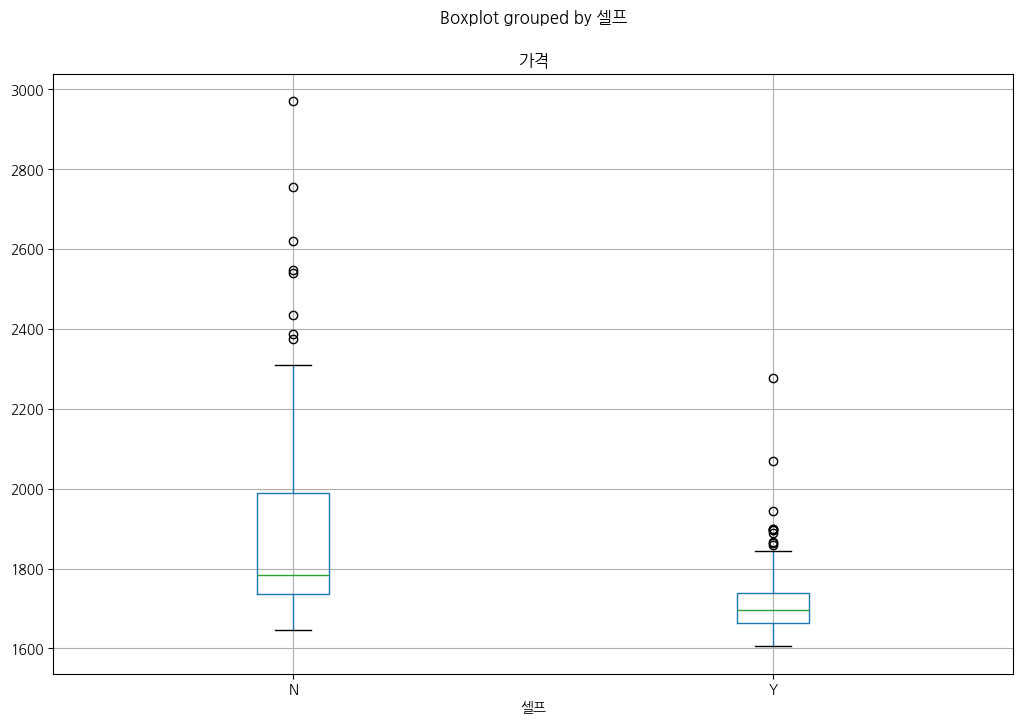

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

oil_data.boxplot(column="가격", by="셀프", figsize=(12, 8))

/tmp/ipykernel_7320/2074384566.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="셀프", y="가격", data=oil_data, palette="Set1", order=["N", "Y"])


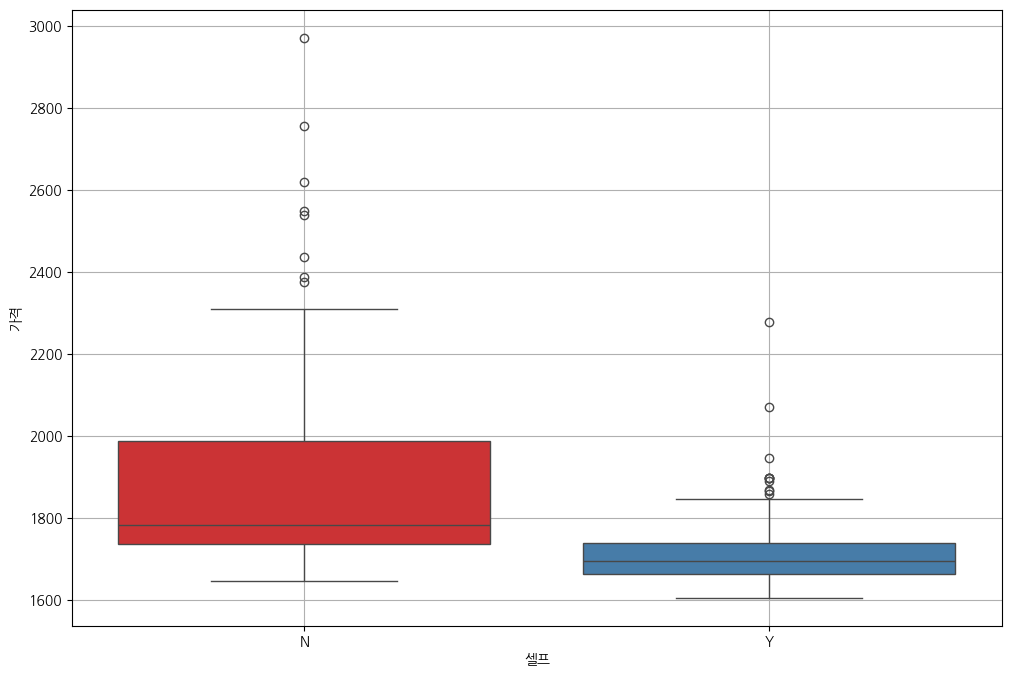

In [29]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="셀프", y="가격", data=oil_data, palette="Set1", order=["N", "Y"])
plt.grid(True)
plt.show()




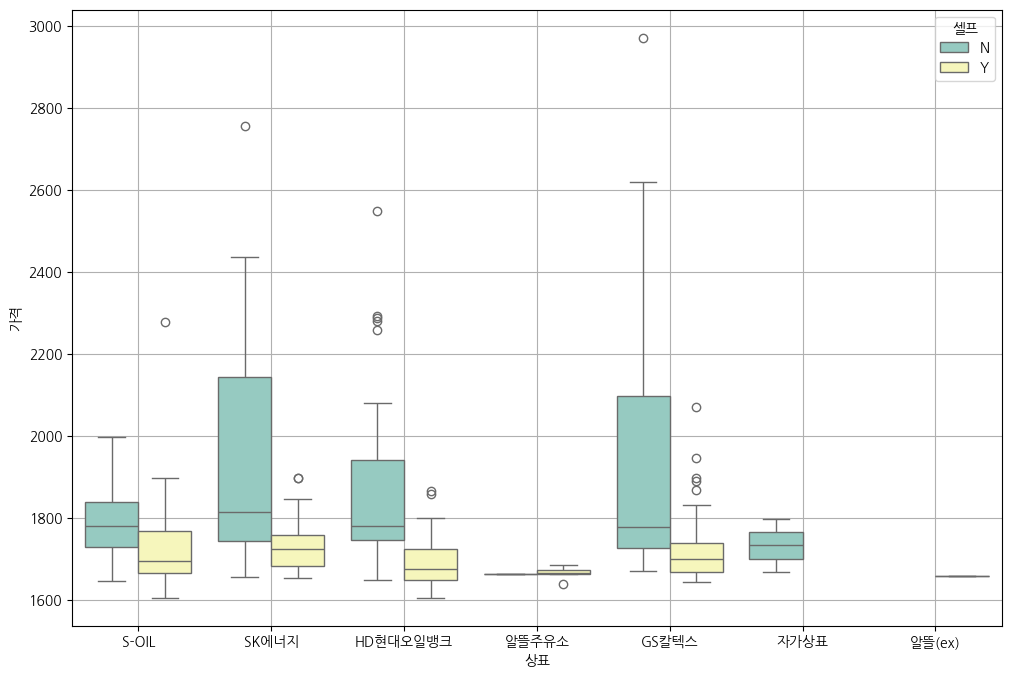

In [39]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="상표", y="가격", hue="셀프", hue_order=["N", "Y"], data=oil_data, palette="Set3")
plt.grid(True)
plt.show()

In [40]:
import json
import folium
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)



In [41]:
oil_data.sort_values(by="가격", ascending=False).head(10)

,상호,주소,가격,셀프,상표,구
308,서계주유소,서울 용산구 청파로 367 (청파동),2971.0,N,GS칼텍스,용산구
31,서남주유소,서울 중구 통일로 30,2756.0,N,SK에너지,중구
130,(주)만정에너지 삼보주유소,서울 강남구 봉은사로 433 (삼성동),2620.0,N,GS칼텍스,강남구
129,(주)제이제이네트웍스 제이제이주유소,서울 강남구 언주로 716,2548.0,N,HD현대오일뱅크,강남구
30,필동주유소,서울 중구 퇴계로 196,2539.0,N,GS칼텍스,중구
128,SK논현주유소,서울 강남구 논현로 747 (논현동),2435.0,N,SK에너지,강남구
127,(주)소모 쎈트럴주유소,서울 강남구 삼성로 335,2388.0,N,GS칼텍스,강남구
193,(주)대양씨앤씨 사직주유소,서울 종로구 사직로 65,2375.0,N,GS칼텍스,종로구
307,한석주유소,서울 용산구 이촌로 164,2310.0,N,SK에너지,용산구
160,(주)옥수하이웨이스테이션,서울 성동구 독서당로 168 (옥수동),2298.0,N,GS칼텍스,성동구


In [43]:
oil_data.sort_values(by="가격", ascending=True).head(10)

,상호,주소,가격,셀프,상표,구
145,(주)서울에너지 직영,서울 성동구 천호대로 324 (용답동),1605.0,Y,S-OIL,성동구
146,㈜성동에너지,서울 성동구 천호대로 392,1605.0,Y,HD현대오일뱅크,성동구
194,(주)자연에너지 국민주유소,서울 동대문구 답십리로 223 (답십리동),1635.0,Y,HD현대오일뱅크,동대문구
59,이케이에너지(주) 강서주유소,서울 강서구 화곡로 273 (화곡동),1638.0,Y,HD현대오일뱅크,강서구
58,화곡역주유소,서울 강서구 강서로 154 (화곡동),1638.0,Y,알뜰주유소,강서구
174,우림주유소,서울 중랑구 용마산로 487 (망우제3동),1643.0,Y,GS칼텍스,중랑구
349,㈜원천주유소,서울 성북구 돌곶이로 142,1643.0,Y,GS칼텍스,성북구
46,㈜동화오일 대원주유소,서울 광진구 용마산로 122 (중곡동),1645.0,Y,GS칼텍스,광진구
91,(주)자연에너지 번동주유소,서울 강북구 한천로 963 (번동),1645.0,Y,HD현대오일뱅크,강북구
350,㈜스마일에너지 신동방주유소,서울 성북구 월계로 84 (장위동),1645.0,Y,S-OIL,성북구


In [44]:
import numpy as np

gu_data = pd.pivot_table(oil_data, index="구", values="가격", aggfunc="mean")
gu_data.head()

,가격
구,
강남구,1959.000000
강동구,1797.461538
강북구,1675.300000
강서구,1717.878788
관악구,1770.142857


In [47]:
import folium

geo_path = "../data/02. skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="OpenStreetMap", attr="OpenStreetMap")

setting = folium.Choropleth(geo_data=geo_str,
                            data=gu_data,
                            columns=[gu_data.index, "가격"],
                            key_on="feature.id",
                            fill_color="PuRd")
setting.add_to(map)
map
